# MLP on MNIST database

This notebook is a report of my experiments on the MNIST database.

In [148]:
import numpy as np
import time
import cPickle, gzip # to load MNIST
import matplotlib.pyplot as plt # to plot figures
%matplotlib inline 
# to plot figures inside the notebook

### Loading MNIST

In [124]:
# Load the dataset
f = gzip.open('first_assignment\\mnist.pkl.gz', 'rb')
trainset, validset, testset = cPickle.load(f)
f.close()

Each set is a tuple :

In [3]:
print type(trainset)

<type 'tuple'>


The first element of each tuple is an array of input images :

In [4]:
for dataset,name in zip([trainset,testset,validset],["train","valid","test"]):
    print dataset[0].shape[0], "%s examples of dimension"%(name), dataset[0].shape[1], "(=28*28)"

50000 train examples of dimension 784 (=28*28)
10000 valid examples of dimension 784 (=28*28)
10000 test examples of dimension 784 (=28*28)


And the second element contains the corresponding labels :

In [5]:
trainset[1]

array([5, 0, 4, ..., 8, 4, 8], dtype=int64)

### Ploting some examples

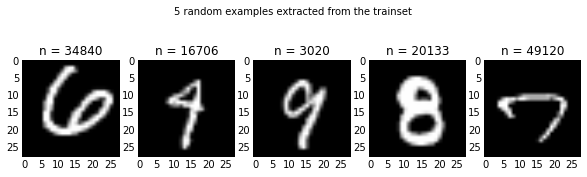

In [7]:
sz = [28,28] # images size

# Random plot of 5 examples from the trainset : 
plt.figure(figsize=(10,3))
plt.gray() # to plot graylevel images
plt.suptitle("5 random examples extracted from the trainset")
for i in range(5):
    n = np.random.randint(0,trainset[0].shape[0],1)[0] # random integer between 0 and 50000
    plt.subplot(1,5,i+1)
    plt.imshow(trainset[0][n].reshape(sz)) # examples have to be reshaped
    plt.title("n = %d"%n)
plt.show()

## Objective

We would like **to train a classifier to recognize those digits.** 

To do so, we are going to train a MLP with one hidden layer of **1000 fully connected neurons** and **sigmoid activation**. The output layer is composed of **10 fully connected neurons with softmax activations**. The networks will be trained using a classical **backpropagation algorithm**.

In [118]:
# Since labels are integers, I need to convert them into usefull vectors : 5 -> [0,0,0,0,0,1,0,0,0,0]
def convert_label(integer_labels):
    label = np.zeros((integer_labels.shape[0], 10))
    label[range(integer_labels.shape[0]),integer_labels] = 1.0
    return label

In [125]:
# Converting trainset and validset labels
trainset = (trainset[0], convert_label(trainset[1]))
validset = (validset[0], convert_label(validset[1]))

#### Cost function for this problem :

In [126]:
# We are going to train the network by minimizing the negative log likelihood
class negative_log_likelihood:
    def compute_cost(self, output_, label):
        return np.sum(-label*np.log(output_))/output_.shape[0]

    def gradient(self, output_, label):
        return -label/(output_)

#### Import my MLP implementation

In [329]:
import first_assignment.first_assignment_classes as fac

#### Instanciation

In [315]:
# Network
mlp_instance = fac.MLP([])
mlp_instance.add(784,1000,fac.Sigmoid()) # add the hidden layer, 1000 neurons with sigmoid activation
mlp_instance.add(1000,10,fac.Softmax())  # add the output layer, 10 neurons with softmax activation
# Cost function
J = negative_log_likelihood()

#### Test over one example

Let's give one input example to the network, and see what's going on...

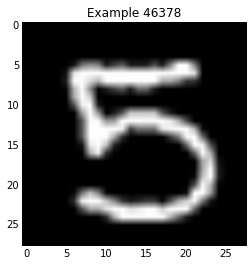

Label : [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Output : [  4.70740514e-41   1.13203891e-22   7.69718397e-24   2.83713304e-11
   9.99840554e-01   1.29811827e-30   1.59318974e-04   1.26584695e-07
   1.68225611e-13   2.64948507e-15]
Decision : 4
Cost : 68.8166370594
Dcost : [[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   -0.00000000e+00  -7.70345834e+29  -0.00000000e+00  -0.00000000e+00
   -0.00000000e+00  -0.00000000e+00]]


In [313]:
n = np.random.randint(0,50000)
plt.figure()
plt.imshow(trainset[0][n].reshape(sz))
plt.title("Example %d"%n)
plt.show()
lab = trainset[1][n]
print "Label :", lab
out = mlp_instance.forward_pass(trainset[0][n])
print "Output :", out.flatten()
cost = J.compute_cost(out,lab)
print "Decision :", out.argmax()
print "Cost :", cost
dcost = J.gradient(out, lab)
print "Dcost :", dcost

The network prediction is false. Which is normal : we have not trained it.

### Checking gradient using finite differences method

Before training our network, let's **check that the implementation is good** by looking at the **gradients** used during a backward pass. 

In fact, we are going to compare : 
- analytical gradients : the ones used during training
- numerical gradients : computed with the finite differences method

Those gradients should be equals.

In [368]:
# Network
mlp_test = fac.MLP([])
mlp_test.add(2,5,fac.Sigmoid())
mlp_test.add(5,2,fac.Softmax())

# Random features and targets
x = np.random.randn(2)
y = np.zeros(2)
y[0]=1.0
# Check
mlp_test.check_gradient(x, y, J, rtol=10**-4, atol=10**-4, eps=0.0001, display=True)

### Analytical Gradients ###
Layer 1
dW
[[-0.10781677  0.03251846 -0.04126235 -0.03467346  0.07940996]
 [ 0.09485279 -0.02860842  0.03630093  0.03050429 -0.06986164]]
dB
[ 0.13301925 -0.04011975  0.05090754  0.04277848 -0.09797227]

Layer 2
dW
[[-0.16476973  0.16476973]
 [-0.28095035  0.28095035]
 [-0.34039786  0.34039786]
 [-0.22076509  0.22076509]
 [-0.13705483  0.13705483]]
dB
[-0.57491975  0.57491975]

### Numerical Gradients ###
Layer 1
dW
[[-0.10781448  0.03251847 -0.0412626  -0.03467309  0.07940851]
 [ 0.09485457 -0.02860841  0.03630074  0.03050458 -0.06986277]]
dB
[ 0.13302275 -0.04011973  0.05090717  0.04277904 -0.09797448]

Layer 2
dW
[[-0.16476873  0.16477074]
 [-0.28094743  0.28095327]
 [-0.34039358  0.34040215]
 [-0.22076329  0.22076689]
 [-0.13705413  0.13705552]]
dB
[-0.57490753  0.57493197]

Gradients are OK.


True

### Training

**Stop criterion** : when the validation cost has not decreased for 3 epochs, then training is stopped

**Saving the best model** : in order to keep the best model, I wrote a method that store the optimal weights into a pickle file. After the training, those weights have to be reloaded to get the best learnt model. See below.

In [320]:
# Training parameters
nepochs_max = 50 # 50 epochs max
l = 0.01 # learning rate
max_no_best = 3 # If the validation score did not improve for 3 epochs, then the learning stop
B = 100 # batch size

history_B100 = mlp_instance.train_model(trainset,  validset, J, learning_rate=l, nepochs_max=nepochs_max,
                         max_no_best=max_no_best, batch_size=B, nexample_per_epoch=None, save_name = "first_assignment\\best_model_B100.pkl")

Init   	 Train Cost = 34.73 	 Valid Cost = 35.31 	 Best Cost = 35.31
Epoch 1 	 Train Cost = 1.08 	 Valid Cost = 1.22 	 Best Cost = 1.22 	 Time = 23s
Epoch 2 	 Train Cost = 1.76 	 Valid Cost = 1.91 	 Best Cost = 1.22 	 Time = 23s
Epoch 3 	 Train Cost = 0.25 	 Valid Cost = 0.56 	 Best Cost = 0.56 	 Time = 22s
Epoch 4 	 Train Cost = 0.36 	 Valid Cost = 0.72 	 Best Cost = 0.56 	 Time = 24s
Epoch 5 	 Train Cost = 0.30 	 Valid Cost = 0.61 	 Best Cost = 0.56 	 Time = 23s
Epoch 6 	 Train Cost = 0.09 	 Valid Cost = 0.48 	 Best Cost = 0.48 	 Time = 24s
Epoch 7 	 Train Cost = 0.17 	 Valid Cost = 0.60 	 Best Cost = 0.48 	 Time = 24s
Epoch 8 	 Train Cost = 0.07 	 Valid Cost = 0.51 	 Best Cost = 0.48 	 Time = 24s
Epoch 9 	 Train Cost = 0.02 	 Valid Cost = 0.39 	 Best Cost = 0.39 	 Time = 22s
Epoch 10 	 Train Cost = 0.01 	 Valid Cost = 0.37 	 Best Cost = 0.37 	 Time = 23s
Epoch 11 	 Train Cost = 0.01 	 Valid Cost = 0.41 	 Best Cost = 0.37 	 Time = 25s
Epoch 12 	 Train Cost = 0.00 	 Valid Cost = 0.37 

#### Plotting cost curves

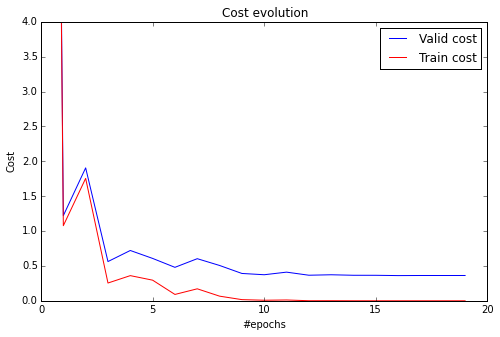

In [347]:
plt.figure(figsize=(8,5))
plt.plot(range(20),history_B100[0], c="b", label="Valid cost")
plt.plot(range(20),history_B100[1], c="r", label = "Train cost")
plt.legend()
plt.ylim([0,4])
plt.ylabel("Cost")
plt.xlabel("#epochs")
plt.title("Cost evolution")
plt.show()

We can observe that, at the end, the **train cost is equal to 0** : the trainset is **overfitted** by our model. The MLP predictions on the trainset are never wrong, and **the model can't learn more.** 

#### Load the best weights 

In [348]:
mlp_instance.load_weights("first_assignment\\best_model_B100.pkl")

#### ... and compute the accuracy over the whole testset :

In [349]:
outputs = mlp_instance.forward_pass(testset[0])
decisions = outputs.argmax(axis=1)
score = np.sum(decisions == testset[1])/10000.

print "Testset score : %.2f percent"%(score*100)

Testset score : 96.08 percent


In [371]:
outputs = mlp_instance.forward_pass(trainset[0])
decisions = outputs.argmax(axis=1)
score = np.sum(decisions == np.argmax(trainset[1], axis=1))/50000.

print "Trainset score : %.2f percent"%(score*100)

Trainset score : 100.00 percent


## Mini batch experiments

I did some experiments to visualize the influence of the batch size on the training : 
- in terms of #epochs 
- in terms of clock time
    
Every other hyper-parameters stay the same. The seed is fixed before each training.

### B = 1

In [344]:
np.random.seed(123456)
# Network
mlp_instance = fac.MLP([])
mlp_instance.add(784,1000,fac.Sigmoid())
mlp_instance.add(1000,10,fac.Softmax())
# Cost function
J = negative_log_likelihood()

nepochs_max = 100 # 50 epochs max
l = 0.005 # learning rate
max_no_best = 3 # If the validation score did not improve for 3 epochs, then the learning stop
B = 1 # batch size

start = time.time()
history_B1 = mlp_instance.train_model(trainset,  validset, J, learning_rate=l, nepochs_max=nepochs_max,
                         max_no_best=max_no_best, batch_size=B, nexample_per_epoch=None, save_name = "first_assignment\\best_model_B1.pkl")
end = time.time()

Init   	 Train Cost = 43.61 	 Valid Cost = 43.17 	 Best Cost = 43.17
Epoch 1 	 Train Cost = 0.69 	 Valid Cost = 0.83 	 Best Cost = 0.83 	 Time = 561s
Epoch 2 	 Train Cost = 0.36 	 Valid Cost = 0.62 	 Best Cost = 0.62 	 Time = 551s
Epoch 3 	 Train Cost = 0.26 	 Valid Cost = 0.57 	 Best Cost = 0.57 	 Time = 548s
Epoch 4 	 Train Cost = 0.19 	 Valid Cost = 0.53 	 Best Cost = 0.53 	 Time = 544s
Epoch 5 	 Train Cost = 0.11 	 Valid Cost = 0.47 	 Best Cost = 0.47 	 Time = 549s
Epoch 6 	 Train Cost = 0.09 	 Valid Cost = 0.47 	 Best Cost = 0.47 	 Time = 564s
Epoch 7 	 Train Cost = 0.06 	 Valid Cost = 0.45 	 Best Cost = 0.45 	 Time = 563s
Epoch 8 	 Train Cost = 0.03 	 Valid Cost = 0.43 	 Best Cost = 0.43 	 Time = 564s
Epoch 9 	 Train Cost = 0.03 	 Valid Cost = 0.44 	 Best Cost = 0.43 	 Time = 563s
Epoch 10 	 Train Cost = 0.02 	 Valid Cost = 0.42 	 Best Cost = 0.42 	 Time = 564s
Epoch 11 	 Train Cost = 0.01 	 Valid Cost = 0.43 	 Best Cost = 0.42 	 Time = 564s
Epoch 12 	 Train Cost = 0.01 	 Valid C

### B = 50

In [343]:
np.random.seed(123456)
# Network
mlp_instance = fac.MLP([])
mlp_instance.add(784,1000,fac.Sigmoid())
mlp_instance.add(1000,10,fac.Softmax())
# Cost function
J = negative_log_likelihood()

nepochs_max = 100 # 50 epochs max
l = 0.005 # learning rate
max_no_best = 3 # If the validation score did not improve for 3 epochs, then the learning stop
B = 50 # batch size

start = time.time()
history_B50 = mlp_instance.train_model(trainset,  validset, J, learning_rate=l, nepochs_max=nepochs_max,
                         max_no_best=max_no_best, batch_size=B, nexample_per_epoch=None, save_name = "first_assignment\\best_model_B50.pkl")
end = time.time()

Init   	 Train Cost = 43.61 	 Valid Cost = 43.17 	 Best Cost = 43.17
Epoch 1 	 Train Cost = 0.70 	 Valid Cost = 0.82 	 Best Cost = 0.82 	 Time = 22s
Epoch 2 	 Train Cost = 0.38 	 Valid Cost = 0.64 	 Best Cost = 0.64 	 Time = 22s
Epoch 3 	 Train Cost = 0.29 	 Valid Cost = 0.59 	 Best Cost = 0.59 	 Time = 26s
Epoch 4 	 Train Cost = 0.20 	 Valid Cost = 0.56 	 Best Cost = 0.56 	 Time = 27s
Epoch 5 	 Train Cost = 0.12 	 Valid Cost = 0.47 	 Best Cost = 0.47 	 Time = 27s
Epoch 6 	 Train Cost = 0.11 	 Valid Cost = 0.49 	 Best Cost = 0.47 	 Time = 28s
Epoch 7 	 Train Cost = 0.08 	 Valid Cost = 0.47 	 Best Cost = 0.47 	 Time = 26s
Epoch 8 	 Train Cost = 0.04 	 Valid Cost = 0.43 	 Best Cost = 0.43 	 Time = 27s
Epoch 9 	 Train Cost = 0.04 	 Valid Cost = 0.44 	 Best Cost = 0.43 	 Time = 26s
Epoch 10 	 Train Cost = 0.02 	 Valid Cost = 0.41 	 Best Cost = 0.41 	 Time = 27s
Epoch 11 	 Train Cost = 0.01 	 Valid Cost = 0.43 	 Best Cost = 0.41 	 Time = 25s
Epoch 12 	 Train Cost = 0.01 	 Valid Cost = 0.42 

### B = 100

In [341]:
np.random.seed(123456)
# Network
mlp_instance = fac.MLP([])
mlp_instance.add(784,1000,fac.Sigmoid())
mlp_instance.add(1000,10,fac.Softmax())
# Cost function
J = negative_log_likelihood()

nepochs_max = 100 # 50 epochs max
l = 0.005 # learning rate
max_no_best = 3 # If the validation score did not improve for 3 epochs, then the learning stop
B = 100 # batch size

start = time.time()
history_B100_v2 = mlp_instance.train_model(trainset,  validset, J, learning_rate=l, nepochs_max=nepochs_max,
                         max_no_best=max_no_best, batch_size=B, nexample_per_epoch=None, save_name = "first_assignment\\best_model_B100_v2.pkl")
end = time.time()

Init   	 Train Cost = 43.61 	 Valid Cost = 43.17 	 Best Cost = 43.17
Epoch 1 	 Train Cost = 0.74 	 Valid Cost = 0.86 	 Best Cost = 0.86 	 Time = 22s
Epoch 2 	 Train Cost = 0.41 	 Valid Cost = 0.66 	 Best Cost = 0.66 	 Time = 22s
Epoch 3 	 Train Cost = 0.26 	 Valid Cost = 0.55 	 Best Cost = 0.55 	 Time = 21s
Epoch 4 	 Train Cost = 0.19 	 Valid Cost = 0.53 	 Best Cost = 0.53 	 Time = 24s
Epoch 5 	 Train Cost = 0.14 	 Valid Cost = 0.47 	 Best Cost = 0.47 	 Time = 32s
Epoch 6 	 Train Cost = 0.13 	 Valid Cost = 0.50 	 Best Cost = 0.47 	 Time = 23s
Epoch 7 	 Train Cost = 0.06 	 Valid Cost = 0.44 	 Best Cost = 0.44 	 Time = 22s
Epoch 8 	 Train Cost = 0.06 	 Valid Cost = 0.45 	 Best Cost = 0.44 	 Time = 25s
Epoch 9 	 Train Cost = 0.03 	 Valid Cost = 0.43 	 Best Cost = 0.43 	 Time = 23s
Epoch 10 	 Train Cost = 0.02 	 Valid Cost = 0.41 	 Best Cost = 0.41 	 Time = 22s
Epoch 11 	 Train Cost = 0.03 	 Valid Cost = 0.45 	 Best Cost = 0.41 	 Time = 25s
Epoch 12 	 Train Cost = 0.01 	 Valid Cost = 0.41 

### B = 200

In [342]:
np.random.seed(123456)
# Network
mlp_instance = fac.MLP([])
mlp_instance.add(784,1000,fac.Sigmoid())
mlp_instance.add(1000,10,fac.Softmax())
# Cost function
J = negative_log_likelihood()

nepochs_max = 100 # 50 epochs max
l = 0.005 # learning rate
max_no_best = 3 # If the validation score did not improve for 3 epochs, then the learning stop
B = 200 # batch size

start = time.time()
history_B200 = mlp_instance.train_model(trainset,  validset, J, learning_rate=l, nepochs_max=nepochs_max,
                         max_no_best=max_no_best, batch_size=B, nexample_per_epoch=None, save_name = "first_assignment\\best_model_B200.pkl")
end = time.time()

Init   	 Train Cost = 43.61 	 Valid Cost = 43.17 	 Best Cost = 43.17
Epoch 1 	 Train Cost = 1.44 	 Valid Cost = 1.47 	 Best Cost = 1.47 	 Time = 36s
Epoch 2 	 Train Cost = 1.38 	 Valid Cost = 1.50 	 Best Cost = 1.47 	 Time = 38s
Epoch 3 	 Train Cost = 0.54 	 Valid Cost = 0.79 	 Best Cost = 0.79 	 Time = 32s
Epoch 4 	 Train Cost = 0.46 	 Valid Cost = 0.72 	 Best Cost = 0.72 	 Time = 33s
Epoch 5 	 Train Cost = 0.37 	 Valid Cost = 0.67 	 Best Cost = 0.67 	 Time = 35s
Epoch 6 	 Train Cost = 0.27 	 Valid Cost = 0.63 	 Best Cost = 0.63 	 Time = 33s
Epoch 7 	 Train Cost = 0.15 	 Valid Cost = 0.52 	 Best Cost = 0.52 	 Time = 33s
Epoch 8 	 Train Cost = 0.11 	 Valid Cost = 0.50 	 Best Cost = 0.50 	 Time = 34s
Epoch 9 	 Train Cost = 0.08 	 Valid Cost = 0.47 	 Best Cost = 0.47 	 Time = 33s
Epoch 10 	 Train Cost = 0.07 	 Valid Cost = 0.48 	 Best Cost = 0.47 	 Time = 37s
Epoch 11 	 Train Cost = 0.05 	 Valid Cost = 0.46 	 Best Cost = 0.46 	 Time = 35s
Epoch 12 	 Train Cost = 0.04 	 Valid Cost = 0.45 

### In terms of #epochs :

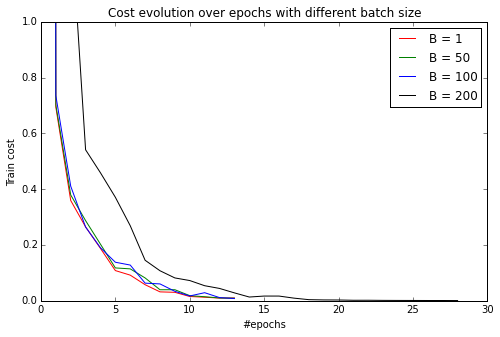

In [355]:
plt.figure(figsize=(8,5))
plt.plot(range(len(history_B1[1])),history_B1[1], c="r", label = "B = 1")
plt.plot(range(len(history_B50[1])),history_B50[1], c="g", label = "B = 50")
plt.plot(range(len(history_B100_v2[1])),history_B100_v2[1], c="b", label="B = 100")
plt.plot(range(len(history_B200[1])),history_B200[1], c="k", label = "B = 200")
plt.legend()
plt.ylim([0,1])
plt.ylabel("Train cost")
plt.xlabel("#epochs")
plt.title("Cost evolution over epochs with different batch size")
plt.show()

### In terms of clock time : 

**Note** : **I only take into account the time spent to update the weights**. Indeed, during each epoch loop, the algorithm first takes time to update weights (forward pass + backard pass) and then compute the cost over the whole trainset (1 forward pass), and the whole validation set (1 forward pass). **I don't take into account the time spent on cost evaluations.**

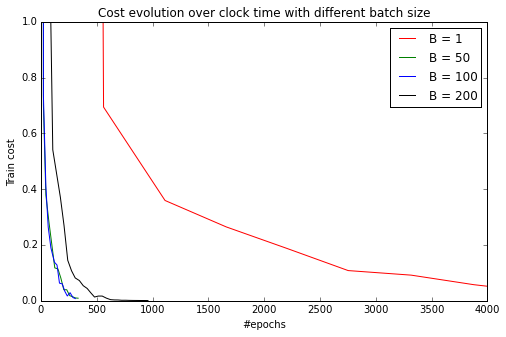

In [367]:
plt.figure(figsize=(8,5))
plt.plot(np.array(history_B1[2]).cumsum(),history_B1[1], c="r", label = "B = 1")
plt.plot(np.array(history_B50[2]).cumsum(),history_B50[1], c="g", label = "B = 50")
plt.plot(np.array(history_B100_v2[2]).cumsum(),history_B100_v2[1], c="b", label="B = 100")
plt.plot(np.array(history_B200[2]).cumsum(),history_B200[1], c="k", label = "B = 200")
plt.legend()
plt.ylim([0,1])
plt.xlim([0,4000])
plt.ylabel("Train cost")
plt.xlabel("#epochs")
plt.title("Cost evolution over clock time with different batch size")
plt.show()